In [1]:
import sys
sys.path.insert(0, "/home/ubuntu/data/code/Modules/")
import skimage
import numpy as np
import pickle
import gc
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.metrics import confusion_matrix
import cv2
import matplotlib.pyplot as plt
from keras import backend
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, BatchNormalization, Flatten, Dropout
from keras.optimizers import SGD,Adadelta
import DataGenerator
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.model_selection import KFold
import random
import glob
import CNN_Module as cnn_module
import models
import DataGenerator_3d
import time
import warnings

Using TensorFlow backend.


In [2]:
import imp
imp.reload(cnn_module)
imp.reload(models)

<module 'models' from '/home/ubuntu/data/code/Modules/models.py'>

In [3]:
sequence_length = 10
model = models.get_luke_3d_model2(input_shape=(140,100,1),sequence_length=sequence_length)
#warnings.filterwarnings('ignore')
augment_train, augment_valid = cnn_module.get_augmentations_train_test()
params_train, params_test = cnn_module.get_params_train_test(140,100,augment_valid,augment_valid)
params_train['dim']=(sequence_length,140,100)
params_test['dim']=(sequence_length,140,100)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
video_path = '/cropped_video100_140'
depth = 10
sequence_length = 10 
sample_gap = 10 
epochs = 25
stepsperepoch = 100
k = 5

start = time.time()

# prep cells for feeding into CNN
cipro_con_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/resistant/'))
#trim_con_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/trimdata/resistant/'))
cipro_sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/susceptible/'))
#trim_sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/trimdata/susceptible/'))

print(len(cipro_con_cells))
#print(len(trim_con_cells))
print(len(cipro_sus_cells))
#print(len(trim_sus_cells))


control_cells = cipro_con_cells
sus_cells = cipro_sus_cells
#control_cells = np.append(cipro_con_cells, trim_con_cells)
#sus_cells = np.append(cipro_sus_cells, trim_sus_cells)

#label cells, and split cells into test and train, making sure to have equal proportion of sus and ctrl in both
control_cells_label = cnn_module.create_label_dict(control_cells,0)
sus_cells_label     = cnn_module.create_label_dict(sus_cells,1)

train_ctrl, test_ctrl = cnn_module.split_train_test(control_cells_label,0.9)
train_sus, test_sus = cnn_module.split_train_test(sus_cells_label,0.9)

train_labels = train_ctrl+train_sus
test_labels = test_ctrl+test_sus
print(len(train_labels))
print(len(test_labels))

all_labels = train_labels+test_labels
#random.shuffle(all_labels)

im_paths_train, im_labels_train, im_paths_test, im_labels_test = cnn_module.get_labels_images_3d(train_labels,test_labels,video_path,sample_gap,depth)
#random.shuffle(im_paths_train)
#random.shuffle(im_paths_test)

model = models.get_luke_3d_model2(input_shape=(140,100,1),sequence_length=sequence_length)
validate_steps = len(im_paths_test)//32

training_generator = DataGenerator_3d.DataGenerator(im_paths_train, im_labels_train, **params_train,depth=depth)
prediction_generator = DataGenerator_3d.DataGenerator(im_paths_test, im_labels_test, **params_test,depth=depth)

#get kfold predictions from training set 
print('kfold training')
train_preds, kfold_val_acc, kfold_acc, kfold_val_loss, kfold_loss = cnn_module.k_fold_train_3d2(all_labels,video_path,model,sample_gap,epochs,stepsperepoch,params_train,params_test,depth,sequence_length,k)    

end = time.time()
run_time = end-start
print('total time =',run_time)



311
351
594
68
kfold training
all data = 662
kfold 1
Test paths =  3036
Train paths =  12098



Epoch 1/25





100/100 [==============================] - 71s 713ms/step - loss: 0.6916 - acc: 0.5369 - val_loss: 0.6907 - val_acc: 0.5705
Epoch 2/25
100/100 [==============================] - 59s 590ms/step - loss: 0.6889 - acc: 0.6116 - val_loss: 0.6901 - val_acc: 0.5638
Epoch 3/25
100/100 [==============================] - 59s 589ms/step - loss: 0.6853 - acc: 0.6478 - val_loss: 0.6866 - val_acc: 0.6059
Epoch 4/25
100/100 [==============================] - 59s 589ms/step - loss: 0.6814 - acc: 0.6644 - val_loss: 0.6811 - val_acc: 0.6281
Epoch 5/25
100/100 [==============================] - 59s 595ms/step - loss: 0.6750 - acc: 0.6866 - val_loss: 0.6756 - val_acc: 0.6312
Epoch 6/25
100/100 [==============================] - 59s 589ms/step - loss: 0.6648 - acc: 0.7166 - val_loss: 0.6839 - val_acc: 0.5864
Epoch 7/25
100/100 [==============================] - 59s 590ms/step - loss: 0.6548 - acc

In [5]:
result = [train_preds, kfold_val_acc, kfold_acc, kfold_val_loss, kfold_loss]

In [13]:
pickle.dump(result, open('/home/ubuntu/data/code/3dCNN/3d_k5_cephfinal1.p','wb'))



In [2]:
import pickle
result_all = pickle.load(open('/home/ubuntu/data/code/3dCNN/3d_k5_cip_trim_final.p','rb'))
kfold_val_acc = result_all[1]
kfold_acc = result_all[2]
kfold_val_loss = result_all[3]
kfold_loss = result_all[4]

In [3]:
import numpy as np
val_acc_avg = np.mean(kfold_val_acc, axis = 0)
print(val_acc_avg)

[0.56153131 0.601478   0.64910455 0.70114687 0.66389628 0.67517113
 0.65611951 0.68507209 0.65415273 0.66199805 0.63814839 0.69626572
 0.66754592 0.67911669 0.67359995 0.67247914 0.65989657 0.67379972
 0.68503049 0.68589271 0.66433314 0.69667016 0.69741494 0.69048716
 0.67189918 0.69570412 0.70874917 0.70296888 0.6753395  0.68991163]


In [5]:
##2d data for comparison

import pickle

result_2d=pickle.load(open('/home/ubuntu/data/code/2dCNN/2d_k5_cip_trim_final.p','rb'))


val_acc_avg_2d = np.mean(result_2d[1], axis = 0)
print(val_acc_avg_2d)

[0.5663772  0.60063385 0.64962105 0.628651   0.61975076 0.5887166
 0.56805793 0.64458854 0.63425187 0.57238569 0.59556035 0.61401927
 0.63325773 0.60544227 0.62596951 0.62840397 0.60969093 0.63532784
 0.60045229 0.57620014 0.61356018 0.62507033 0.60215615 0.64083755
 0.61496614 0.64420936 0.62870624 0.63682717 0.63789297 0.65129439]


(0.5, 1)

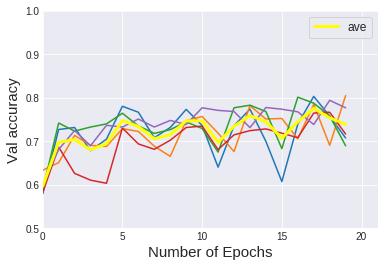

In [7]:
#val acc
x_vals=np.arange(0,20)
plt.style.use('seaborn-darkgrid')

va_ave = np.mean(kfold_val_acc,0)

for i in np.arange(0,len(kfold_val_acc)):
    plt.plot(x_vals,kfold_val_acc[i]) 
plt.plot(x_vals, va_ave, label = 'ave', linewidth =3,color='yellow')    

plt.legend(loc='upper right',frameon=True, fontsize=12)
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Val accuracy', size = 15)
plt.xticks(np.arange(0, 35, 5))
plt.xlim(0,21)
plt.ylim(0.5,1)

#plt.savefig('/home/ubuntu/data/figs/2dk_cs_val_acc.png', dpi=500)

(0.5, 1)

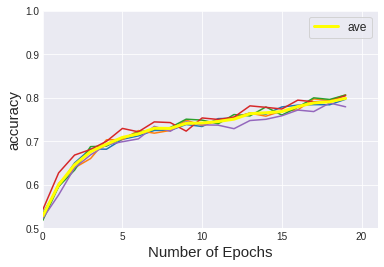

In [8]:
#acc
x_vals=np.arange(0,20)
plt.style.use('seaborn-darkgrid')

a_ave = np.mean(kfold_acc,0)

for i in np.arange(0,len(kfold_acc)):
    plt.plot(x_vals,kfold_acc[i]) 
plt.plot(x_vals, a_ave, label = 'ave', linewidth =3,color='yellow')    

plt.legend(loc='upper right',frameon=True, fontsize=12)
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('accuracy', size = 15)
plt.xticks(np.arange(0, 35, 5))
plt.xlim(0,21)
plt.ylim(0.5,1)

(0.5, 1)

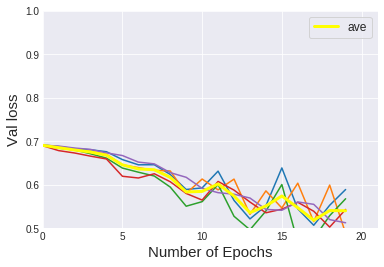

In [9]:
#val loss
x_vals=np.arange(0,20)
plt.style.use('seaborn-darkgrid')

vl_ave = np.mean(kfold_val_loss,0)

for i in np.arange(0,len(kfold_val_loss)):
    plt.plot(x_vals,kfold_val_loss[i]) 
plt.plot(x_vals, vl_ave, label = 'ave', linewidth =3,color='yellow')    

plt.legend(loc='upper right',frameon=True, fontsize=12)
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Val loss', size = 15)
plt.xticks(np.arange(0, 35, 5))
plt.xlim(0,21)
plt.ylim(0.5,1)

(0, 21)

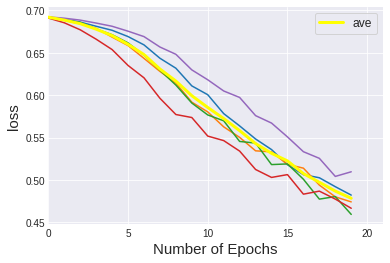

In [10]:
#loss
x_vals=np.arange(0,20)
plt.style.use('seaborn-darkgrid')

l_ave = np.mean(kfold_loss,0)

for i in np.arange(0,len(kfold_val_acc)):
    plt.plot(x_vals,kfold_loss[i]) 
plt.plot(x_vals, l_ave, label = 'ave', linewidth =3,color='yellow')    

plt.legend(loc='upper right',frameon=True, fontsize=12)
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('loss', size = 15)
plt.xticks(np.arange(0, 35, 5))
plt.xlim(0,21)


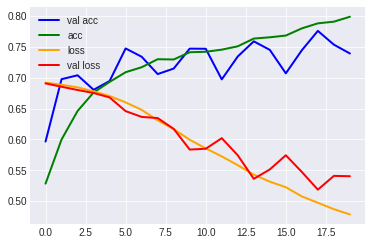

In [11]:
## plotting averages 
plt.plot(x_vals, va_ave, label = 'val acc', linewidth =2,color='blue')    
plt.plot(x_vals, a_ave, label = 'acc', linewidth =2,color='green')    
plt.plot(x_vals, l_ave, label = 'loss', linewidth =2,color='orange')    
plt.plot(x_vals, vl_ave, label = 'val loss', linewidth =2,color='red')    
plt.legend()


([<matplotlib.axis.XTick at 0x7fba9765dd30>,
 <a list of 7 Text xticklabel objects>)

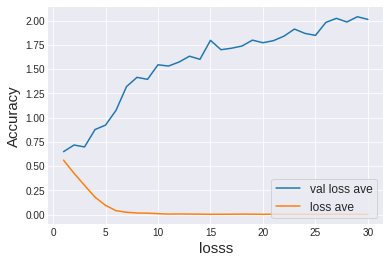

In [9]:
# plot ave loss and val loss
x_vals=np.arange(1,31)
val_loss_ave = np.mean(kfold_val_loss, axis = 0)
loss_ave = np.mean(kfold_loss, axis = 0)

plt.style.use('seaborn-darkgrid')
plt.plot(x_vals,val_loss_ave,label='val loss ave')
plt.plot(x_vals,loss_ave,label='loss ave')
plt.legend(loc='lower right',frameon=True, fontsize=12)
plt.xlabel('losss', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.xticks(np.arange(0, 35, 5))
#plt.xlim(0,31)
#plt.ylim(0.5,0.80)

([<matplotlib.axis.XTick at 0x7fba979036a0>,
 <a list of 7 Text xticklabel objects>)

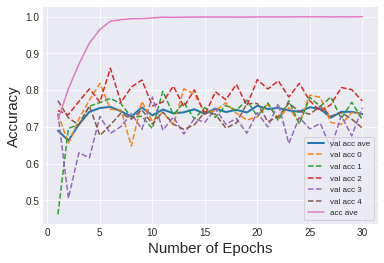

In [12]:
#plotting ave acc and val acc
x_vals=np.arange(1,31)
val_acc_ave = np.mean(kfold_val_acc, axis = 0)
acc_ave = np.mean(kfold_acc, axis = 0)

plt.style.use('seaborn-darkgrid')
plt.plot(x_vals,val_acc_ave,label='val acc ave',linewidth='2')
plt.plot(x_vals,kfold_val_acc[0],label='val acc 0',linestyle='--')
plt.plot(x_vals,kfold_val_acc[1],label='val acc 1',linestyle='--')
plt.plot(x_vals,kfold_val_acc[2],label='val acc 2',linestyle='--')
plt.plot(x_vals,kfold_val_acc[3],label='val acc 3',linestyle='--')
plt.plot(x_vals,kfold_val_acc[4],label='val acc 4',linestyle='--')

plt.plot(x_vals,acc_ave,label='acc ave')
plt.legend(loc='lower right',frameon=True, fontsize=8)
#plt.title('Sample gap vs accuracy')
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.xticks(np.arange(0, 35, 5))
#plt.xlim(0,31)
#plt.ylim(0.5,0.80)